In [20]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

In [21]:
def prepare_graph(path):
    data = pd.read_csv(path)
    st = set()
    for elem in data['id_1']:
        st.add(elem)
    for elem in data['id_2']:
        st.add(elem)
    st = list(st)

    tags = list()
    for tag in data['matches']:
        lst = tag.split('#')
        for elem in lst:
            tags.append(elem)
    tmp = np.asarray(tags)
    result = np.unique(tmp, return_counts=True)
    n = len(result[0])
    pop_tags = []
    for i in range(n):
        pop_tags.append((result[0][i], result[1][i]))

    tags = []
    pop_tags = sorted(pop_tags, key=lambda x: -x[1])[120:]
    for elem in pop_tags:
        tags.append(elem[0])
    tags = set(tags)

    block = []
    weight = []
    n = len(data['id_1'])
    g = nx.DiGraph()
    g.add_nodes_from(st)
    for i in range(n):
        words = []
        first = data['id_1'].iloc[i]
        second = data['id_2'].iloc[i]
        tag = data['matches'].iloc[i].split('#')


        flag = 0
        for tmp in tag:
            elem = tmp.split(' ')
            words += elem

            if tmp in tags:
                flag = 1

        if flag == 1:
            for elem in tag:
                elem_new = elem.split(' ')
                words += elem_new
            words = np.asarray(words)
            p = 1 - len(np.unique(words)) * 1.0 / len(words)
            pp = np.random.binomial(1, p, 1).tolist()[0]

            if p != 0:
                if pp != 1:
                    g.add_edge(first, second, weight=p)
                else:
                    tmp = random.randint(0, 2)
                    if tmp == 0:
                        g.add_edge(second, first, weight=p)
                    elif tmp == 1:
                        g.add_edge(second, first, weight=p)
                        g.add_edge(first, second, weight=p)

    g.remove_nodes_from(list(nx.isolates(g)))
    degrees = dict()
    for node, val in g.degree():
        degrees[node] = val
    ids = list(g.nodes())

    degree = []
    for elem in ids:
        degree.append(degrees[elem])
    time = []
    colors = []
    state = []
    for elem in ids:
        tmp = random.randint(3, 7)
        time.append(tmp)
        tmp = random.randint(0, 1)
        # 0 - S
        # 1 - I
        # 2 - R
        if tmp == 0:
            colors.append('blue')
        elif tmp == 1:
            colors.append('red')
        else:
            colors.append('green')
        state.append(tmp)

    d = {'id': ids, 'state': state, 'time': time, 'degree': degree}
    nodes = pd.DataFrame(data=d)
    return g, nodes, colors

Удалены ребра, по которым болезнь не передается. те, вес которых равен 0 и те, которые заблокированы с вероятностью 1 - p. 

На картинке ниже красным цветом изображены заболевшие вершины, синим- здоровые, но которые могут заболеть, зеленым - вершины с иммунитетом.

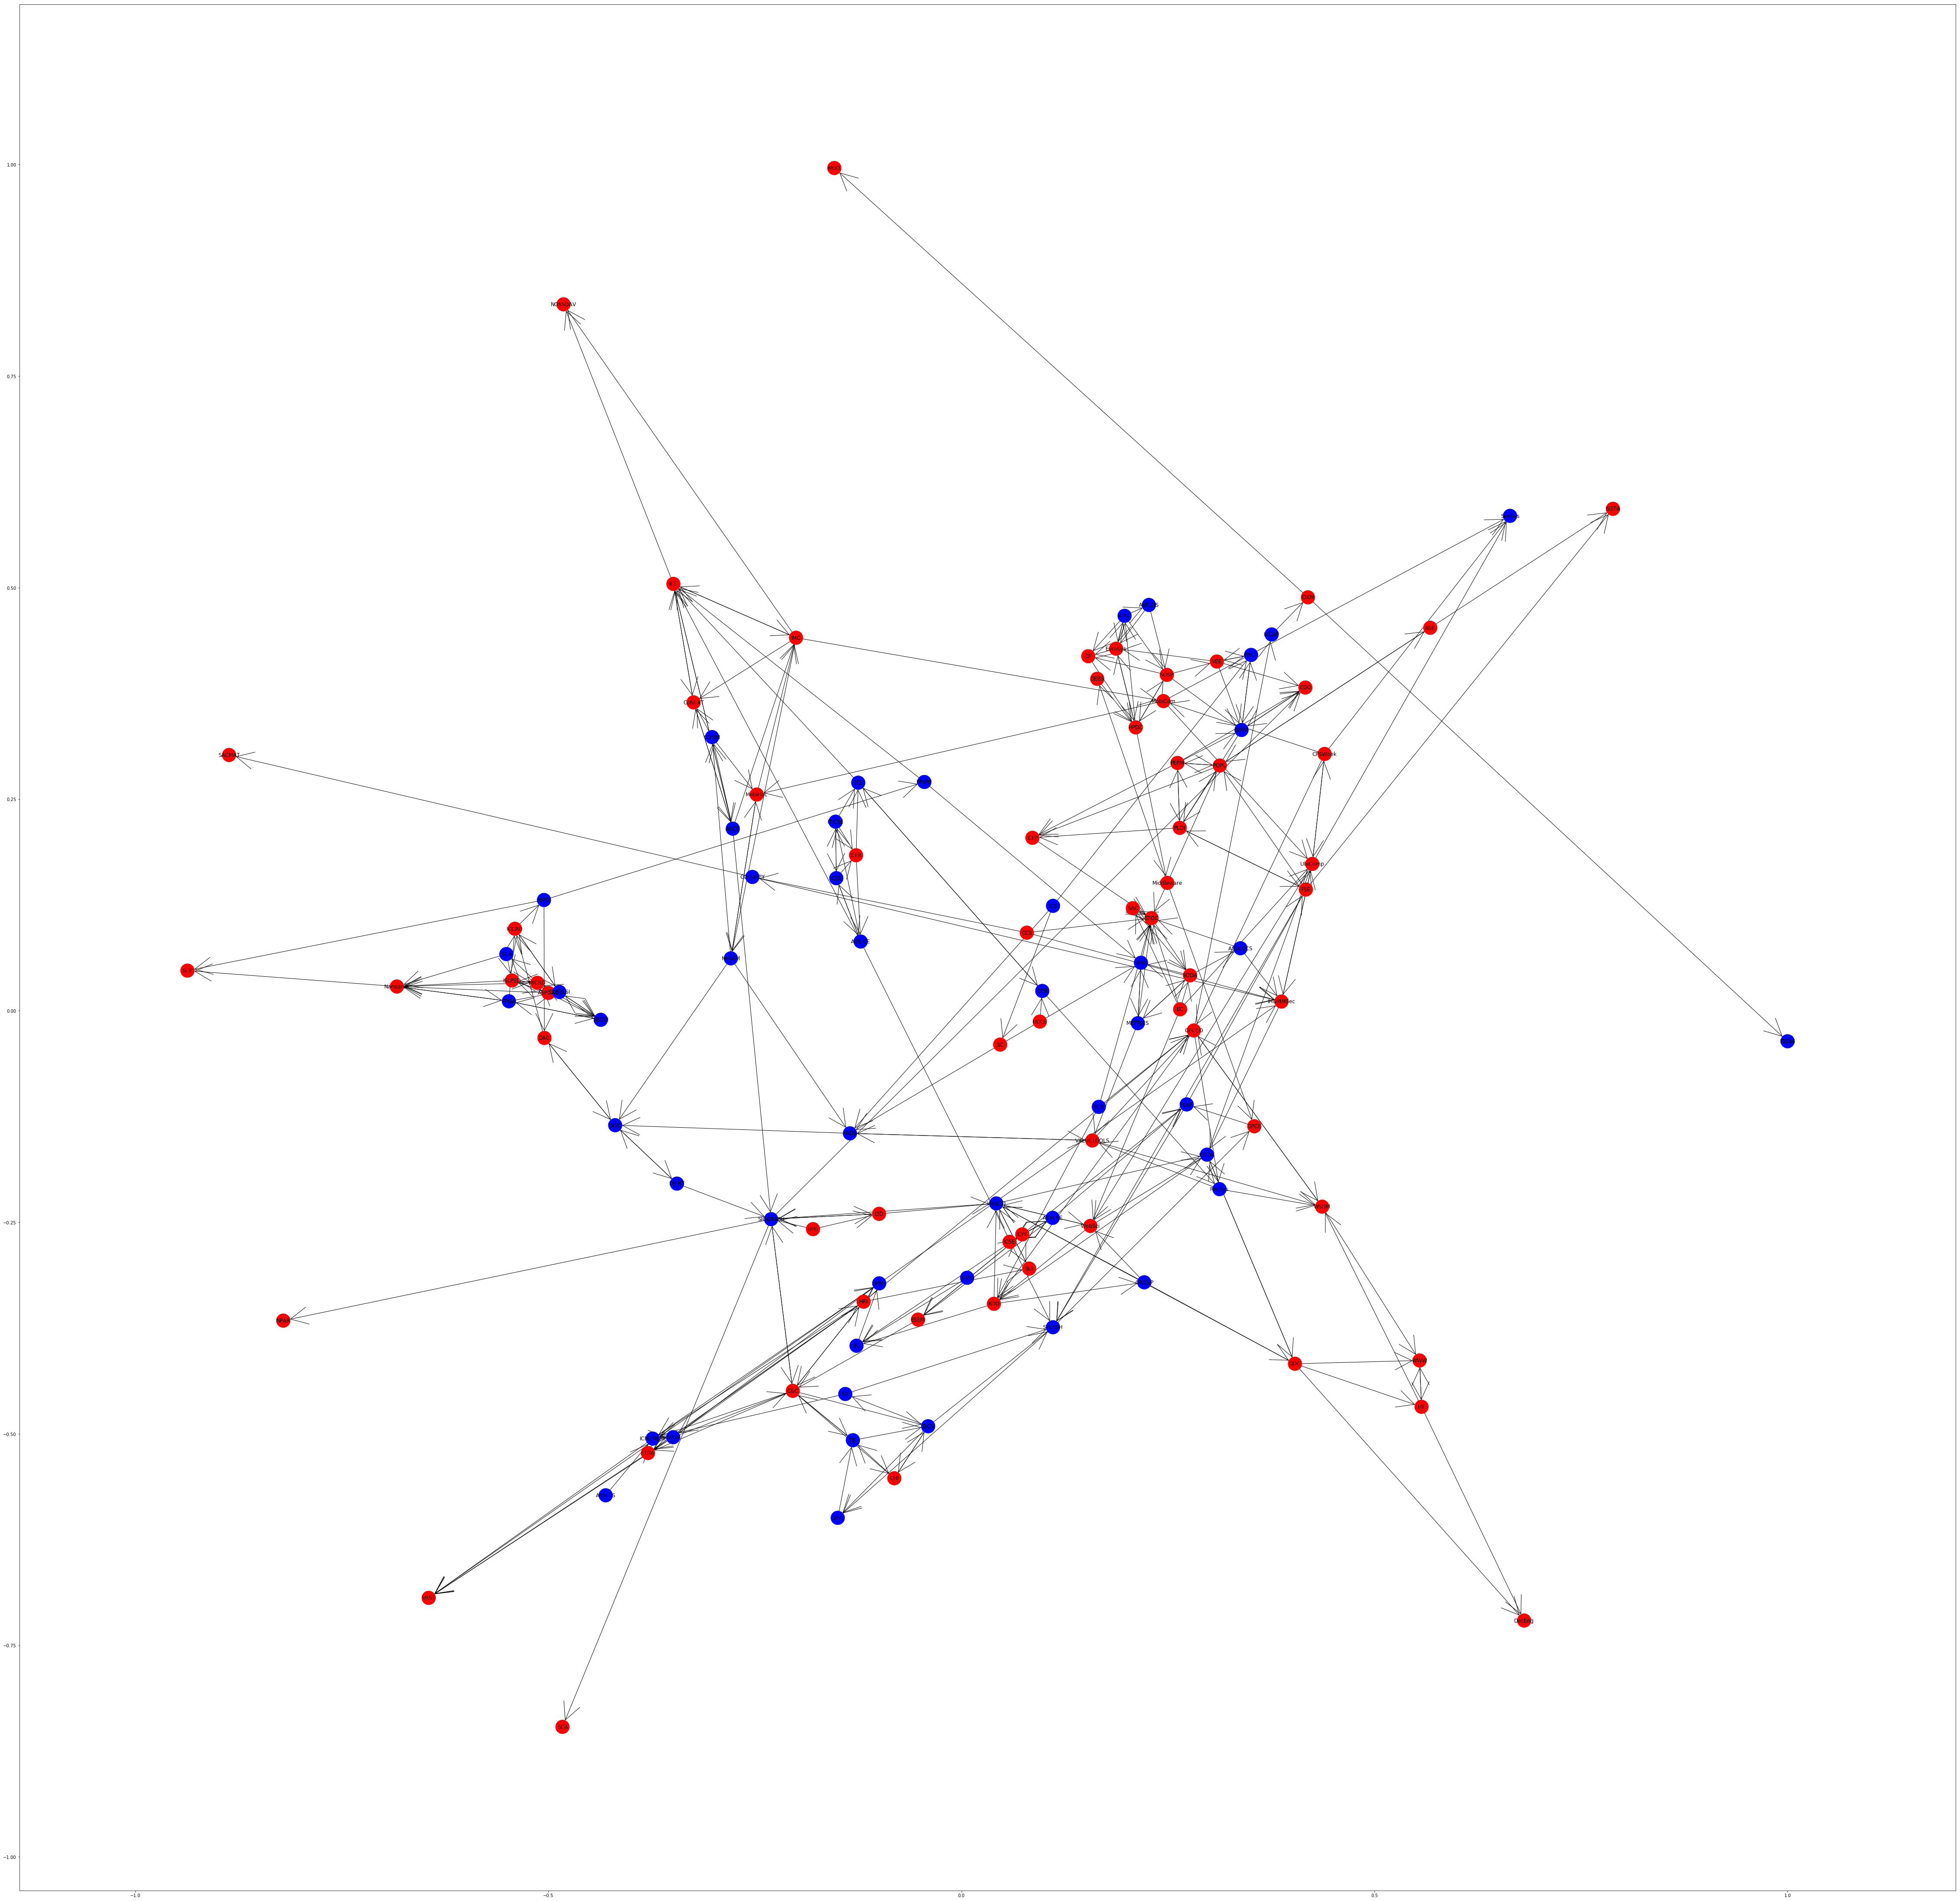

In [22]:
g, nodes_new, colors = prepare_graph('acm.csv')
pos = nx.spring_layout(g)
fig = plt.figure(figsize=(80, 80))
ax = fig.add_subplot(1, 1, 1)
nx.draw_networkx(g, ax=ax, arrowsize=100, arrowstyle='->', pos=pos, node_color=colors, node_size=1000, with_labels=True)
plt.savefig("from.png")

In [23]:
time_period = 8

# Without strategy for comparison

In [24]:
def death_of_dease(g, nodes, t):
    if np.prod(np.isnan(nodes['state'][nodes['state'] == 1])) == 1:
        print('Time of desease`s death', t)
        return False
    for edge in g.edges():
        first = edge[0]
        j = nodes['id'][nodes['id'] == first].index[0]
        s_state = nodes['state'].iloc[j]
        f_time = nodes['time'].iloc[j]
        if g.has_edge(edge[0], edge[1]) and s_state == 1 and f_time > 0:
            k = nodes['id'][nodes['id'] == edge[1]].index[0]
            if nodes['state'].iloc[k] == 0:
                nodes['time'].iloc[k] = random.randint(3, 7)
                nodes['state'].iloc[k] = 1
            nodes['time'].iloc[j] -= 1
            if nodes['time'].iloc[j] == 0:
                nodes['state'].iloc[j] = 2
        else:
            r = nodes['id'][nodes['id'] == edge[1]].index[0]
            if  nodes['state'].iloc[r] == 1 and nodes['time'].iloc[r] > 0:
                nodes['time'].iloc[r] -= 1
            if nodes['time'].iloc[r] == 0:
                nodes['state'].iloc[r] = 2
    return True

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Number of nodes which were deseased in this period time = 8: 107 from 113
deseased / all: 0.9469026548672567
cost: 12840$


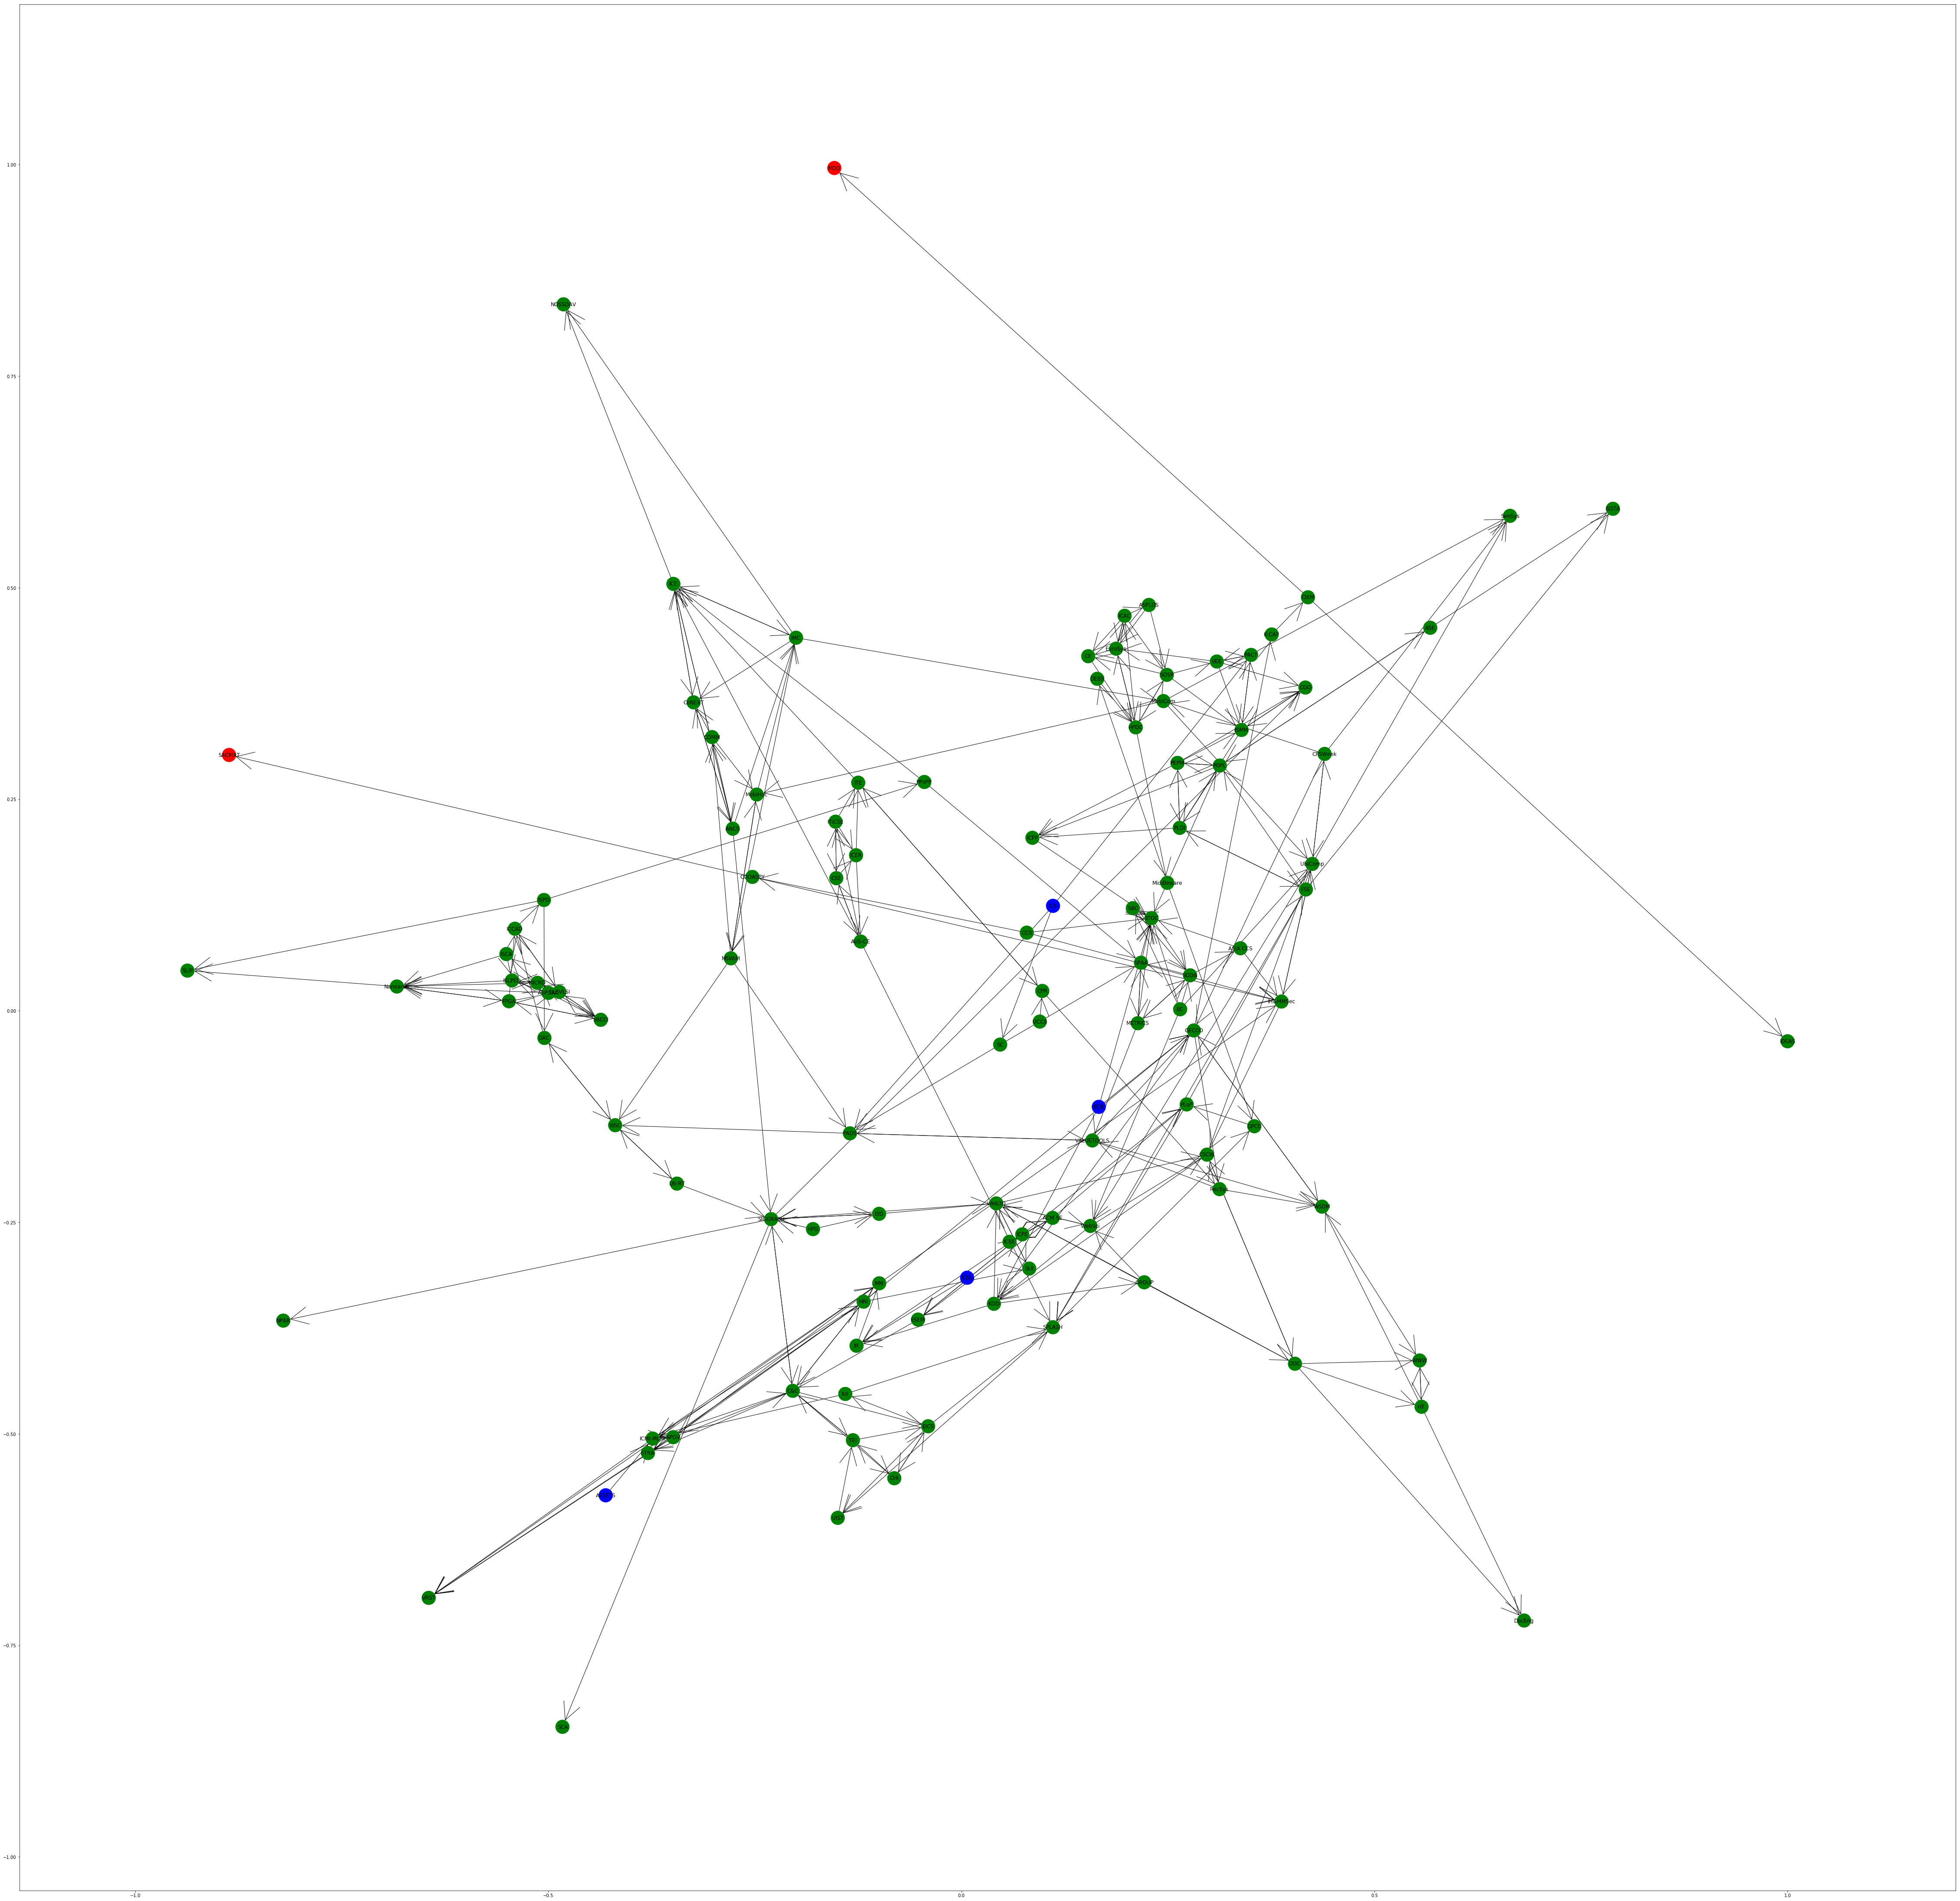

In [25]:
nodes = nodes_new.copy()

quant_i = nodes['state'].where(nodes['state'] == 1).sum()


for t in range(time_period):
    if death_of_dease(g, nodes, t) == False:
        break
colors_new = []
for elem in nodes['state']:
    if elem == 0:
        colors_new.append('blue')
    elif elem == 1:
        colors_new.append('red')
    else:
        colors_new.append('green')
fig = plt.figure(figsize=(80, 80))
ax = fig.add_subplot(1, 1, 1)
nx.draw_networkx(g, ax=ax, arrowsize=100, arrowstyle='->', pos=pos, node_color=colors_new, node_size=1000, with_labels=True)
plt.savefig("without_strategy.png")
print('Number of nodes which were deseased in this period time = 8: {} from {}'.format(int((nodes['state'].where(nodes['state'] == 2).sum() / 2)), len(nodes['id'])))
res_without = int((nodes['state'].where(nodes['state'] == 2).sum() / 2)) / len(nodes['id'])
cost_without = int((nodes['state'].where(nodes['state'] == 2).sum() / 2)) * 120
print('deseased / all:', res_without)
print('cost: {}$'.format(int(cost_without)))


In [26]:
while True:
    if death_of_dease(g, nodes, t) == False:
        break
    t += 1

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Time of desease`s death 9


# First strategy

In [27]:
nodes = nodes_new.copy()

quant_i = nodes['state'].where(nodes['state'] == 1).sum()
quant_s = 0
for elem in nodes['state'].where(nodes['state'] == 0):
    if elem == 0:
        quant_s += 1
print("Number of nodes type S:", quant_s)
quant_vaccine = int(quant_s * 0.1)
print('Number of Infectious nodes which can be vaccinated:', quant_vaccine)

print('List of vertices needed to be vaccinated\n')
tmp = []
for i in range(len(nodes['id'])):
    tmp.append((nodes['id'].iloc[i], nodes['degree'].iloc[i]))
tmp = sorted(tmp, key=lambda x: -x[1])
count = 0
i = 0
while i < len(nodes['id']) and count < quant_vaccine:
    j = nodes['id'][nodes['id'] == tmp[i][0]].index[0]
    if nodes['state'].iloc[j] == 0:
        in_edges = g.in_edges(nodes['id'].iloc[j])
        for edge in in_edges:
            if count >= quant_vaccine:
                break
            k = nodes['id'][nodes['id'] == edge[0]].index[0]
            if nodes['state'].iloc[k] == 1:
                count += 1
                nodes['state'].iloc[j] = 2
                print(nodes['id'].iloc[j])
                break
    i += 1


Number of nodes type S: 48
Number of Infectious nodes which can be vaccinated: 4
List of vertices needed to be vaccinated

SIGGRAPH
Web3D
ISMM
ICMI-MLMI


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [28]:

for t in range(time_period):
    if death_of_dease(g, nodes, t) == False:
        break

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [29]:
colors_new = []
for elem in nodes['state']:
    if elem == 0:
        colors_new.append('blue')
    elif elem == 1:
        colors_new.append('red')
    else:
        colors_new.append('green')

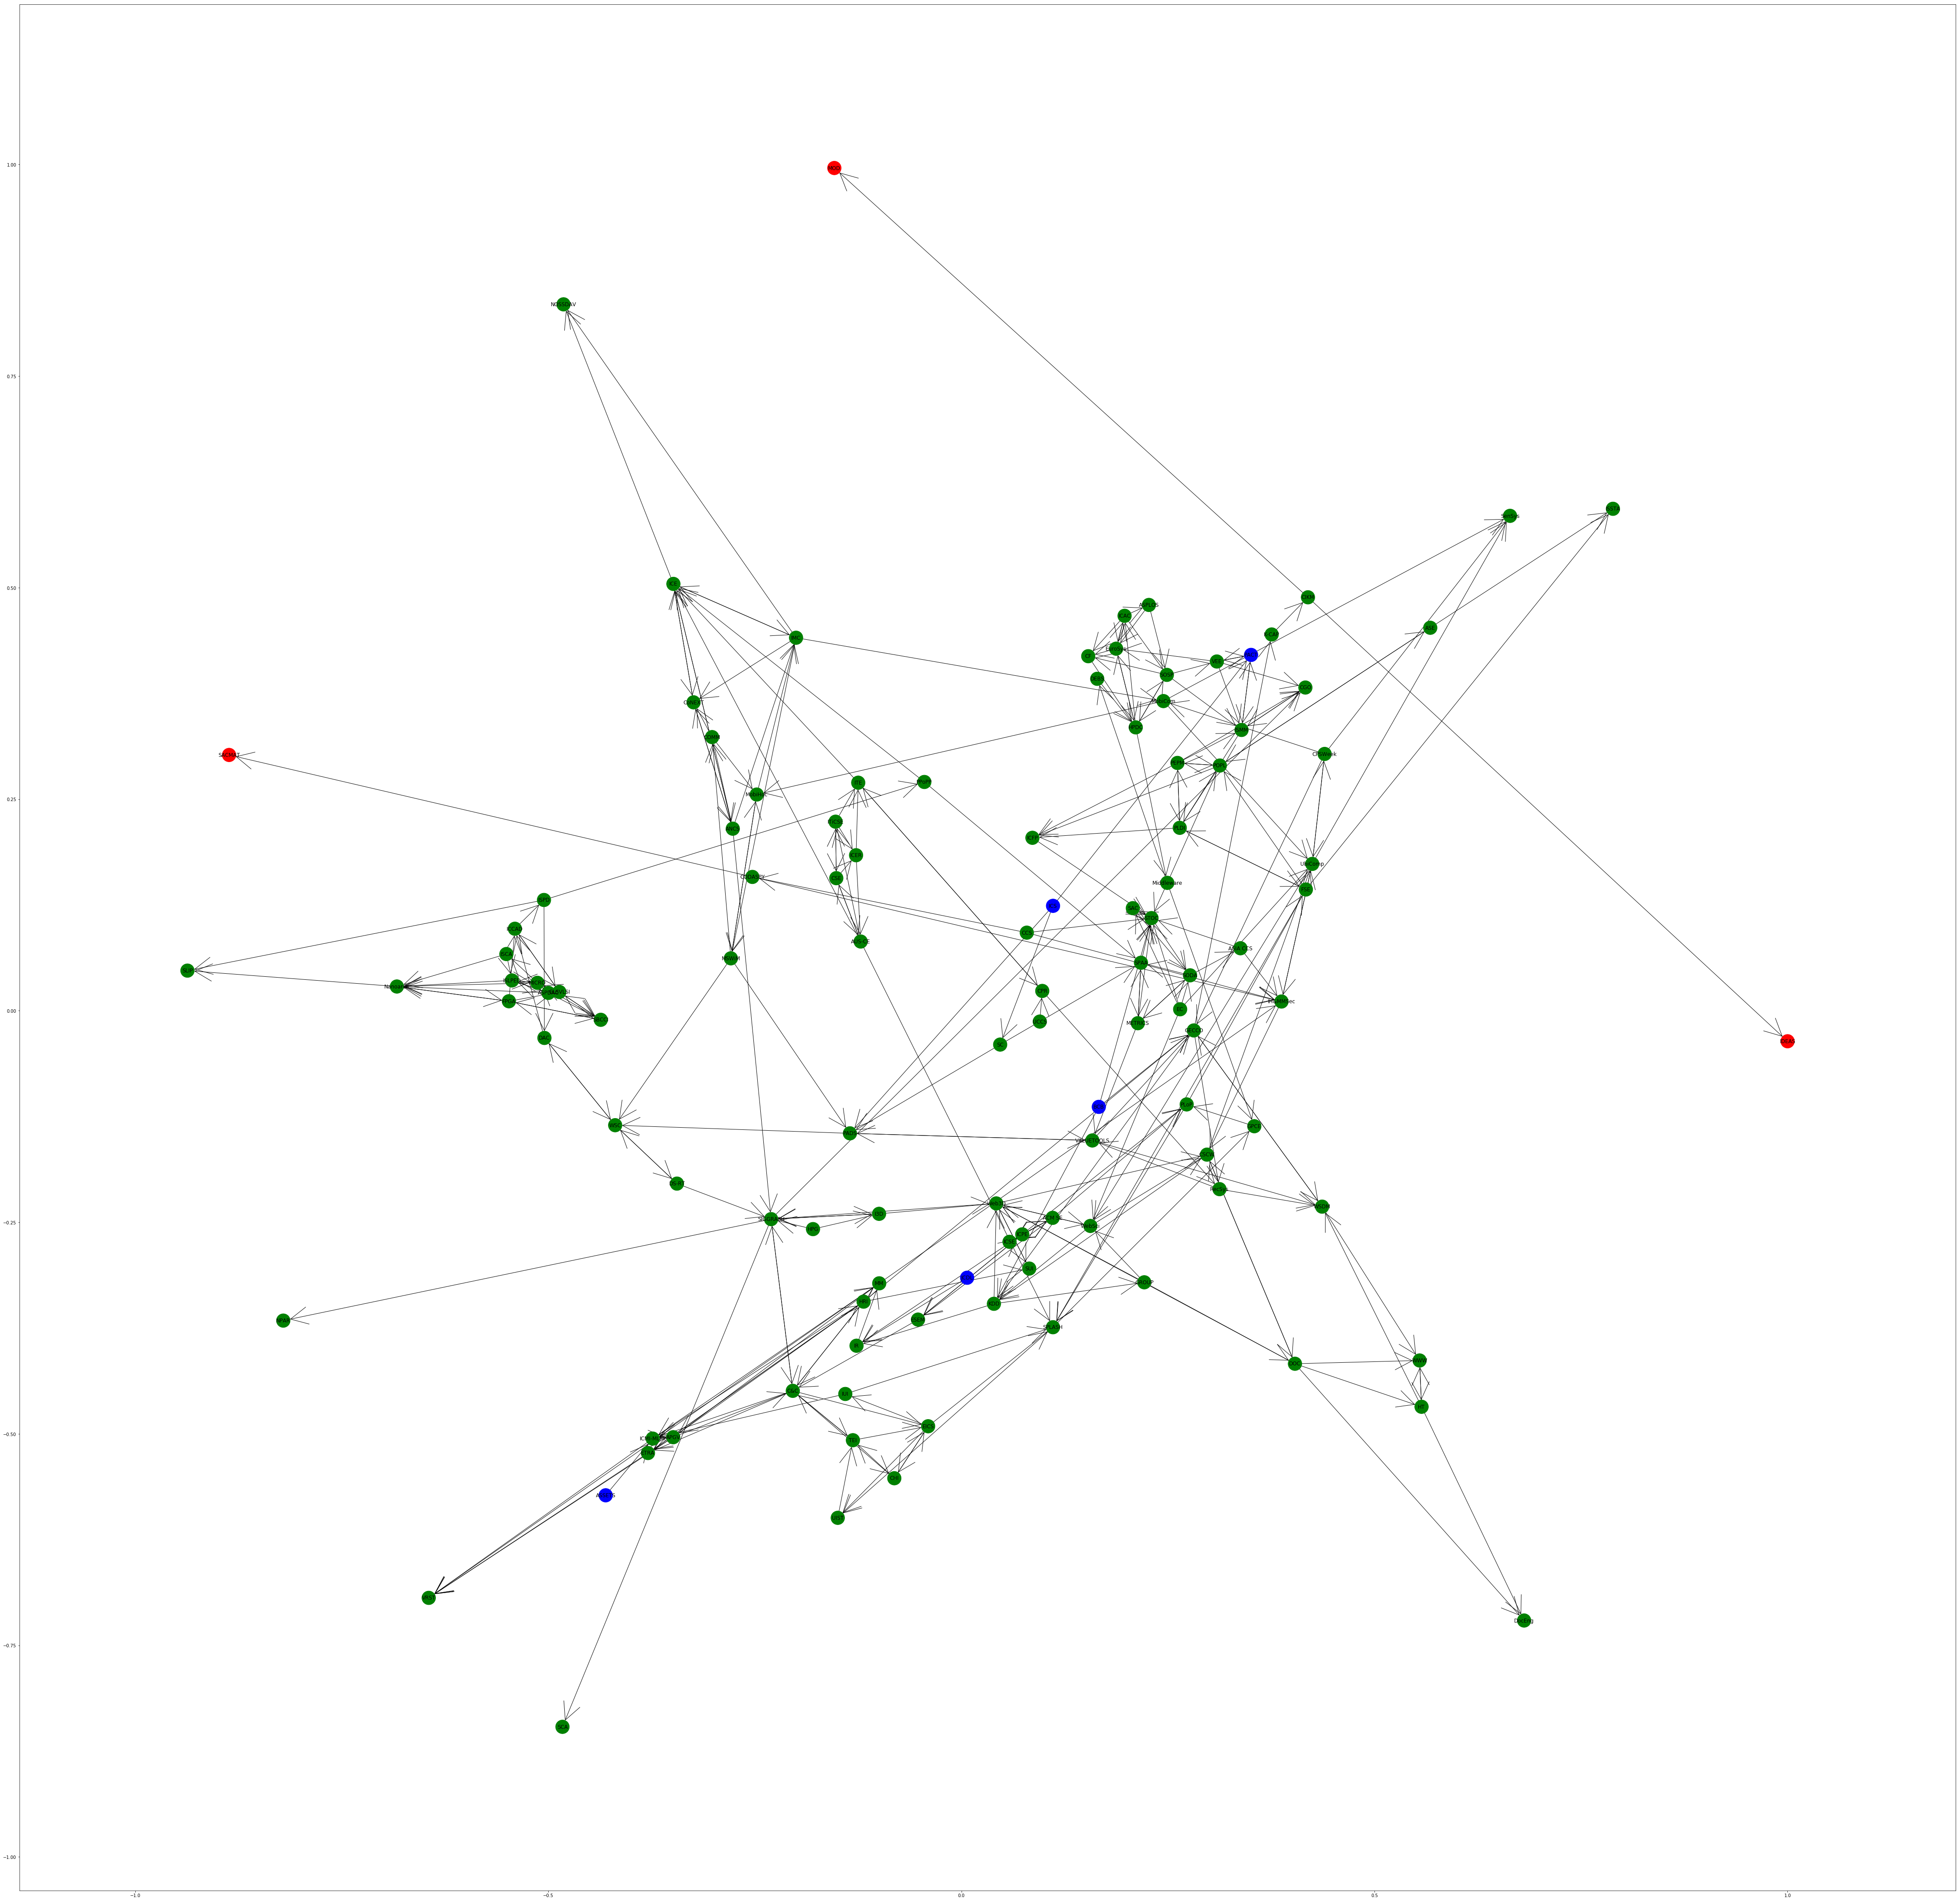

In [30]:
fig = plt.figure(figsize=(80, 80))
ax = fig.add_subplot(1, 1, 1)
nx.draw_networkx(g, ax=ax, arrowsize=100, arrowstyle='->', pos=pos, node_color=colors_new, node_size=1000, with_labels=True)
plt.savefig("to_first.png")

In [31]:
print('Number of nodes which were deseased in this period time = 8: {} from {}'.format(int((nodes['state'].where(nodes['state'] == 2).sum() / 2)), len(nodes['id'])))
res1 = (nodes['state'].where(nodes['state'] == 2).sum() / 2) /  len(nodes['id'])
cost1 = int((nodes['state'].where(nodes['state'] == 2).sum() / 2)) * 120 - 120 * quant_vaccine + 500 * quant_vaccine
print('deseased / all:', res1)
print('cost: {}$'.format(int(cost1)))
while True:
    if death_of_dease(g, nodes, t) == False:
        break
    t += 1

Number of nodes which were deseased in this period time = 8: 105 from 113
deseased / all: 0.9292035398230089
cost: 14120$


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Time of desease`s death 9


# Second strategy

In [32]:
nodes = nodes_new.copy()

quant_i = nodes['state'].where(nodes['state'] == 1).sum()
quant_s = 0
for elem in nodes['state'].where(nodes['state'] == 0):
    if elem == 0:
        quant_s += 1
print("Number of nodes type S:", quant_s)
quant_vaccine = int(quant_s * 0.1)
print('Number of Infectious nodes which can be vaccinated:', quant_vaccine)


Number of nodes type S: 48
Number of Infectious nodes which can be vaccinated: 4


In [33]:
components = []
for elem in nx.strongly_connected_components(g):
    components.append((elem, len(elem)))
components = sorted(components, key=lambda x: -x[1])

count = 0
for component in components:
    list_nodes = component[0]
    list_nodes = list(list_nodes)
    for i in range(len(list_nodes)):
        list_nodes[i] = (list_nodes[i], nodes['degree'].iloc[nodes['id'][nodes['id'] == list_nodes[i]].index[0]])
    list_nodes = sorted(list_nodes, key=lambda x: -x[1])
    
    i = 0
    while i < len(list_nodes) and count < quant_vaccine:
        j = nodes['id'][nodes['id'] == list_nodes[i][0]].index[0]
        if nodes['state'].iloc[j] == 0:
            edges = g.in_edges(list_nodes[i][0])
            for edge in edges:
                print(edge)
                if count >= quant_vaccine:
                    break
                k = nodes['id'][nodes['id'] == edge[0]].index[0]
                print(nodes['state'].iloc[k])
                if nodes['state'].iloc[k] == 1:
                    count += 1
                    nodes['state'].iloc[j] = 2
                    print(nodes['id'].iloc[j])
                    break
        i += 1

('ANCS', 'SIGGRAPH')
0
('C&C', 'SIGGRAPH')
1
SIGGRAPH
('DOC', 'Web3D')
1
Web3D
('CGO', 'ISMM')
1
ISMM
('DOC', 'CSCW')
1


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


CSCW


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Number of nodes which were deseased in this period time = 8: 107 from 113
deseased / all: 0.9469026548672567
cost: 14360$
Time of desease`s death 9


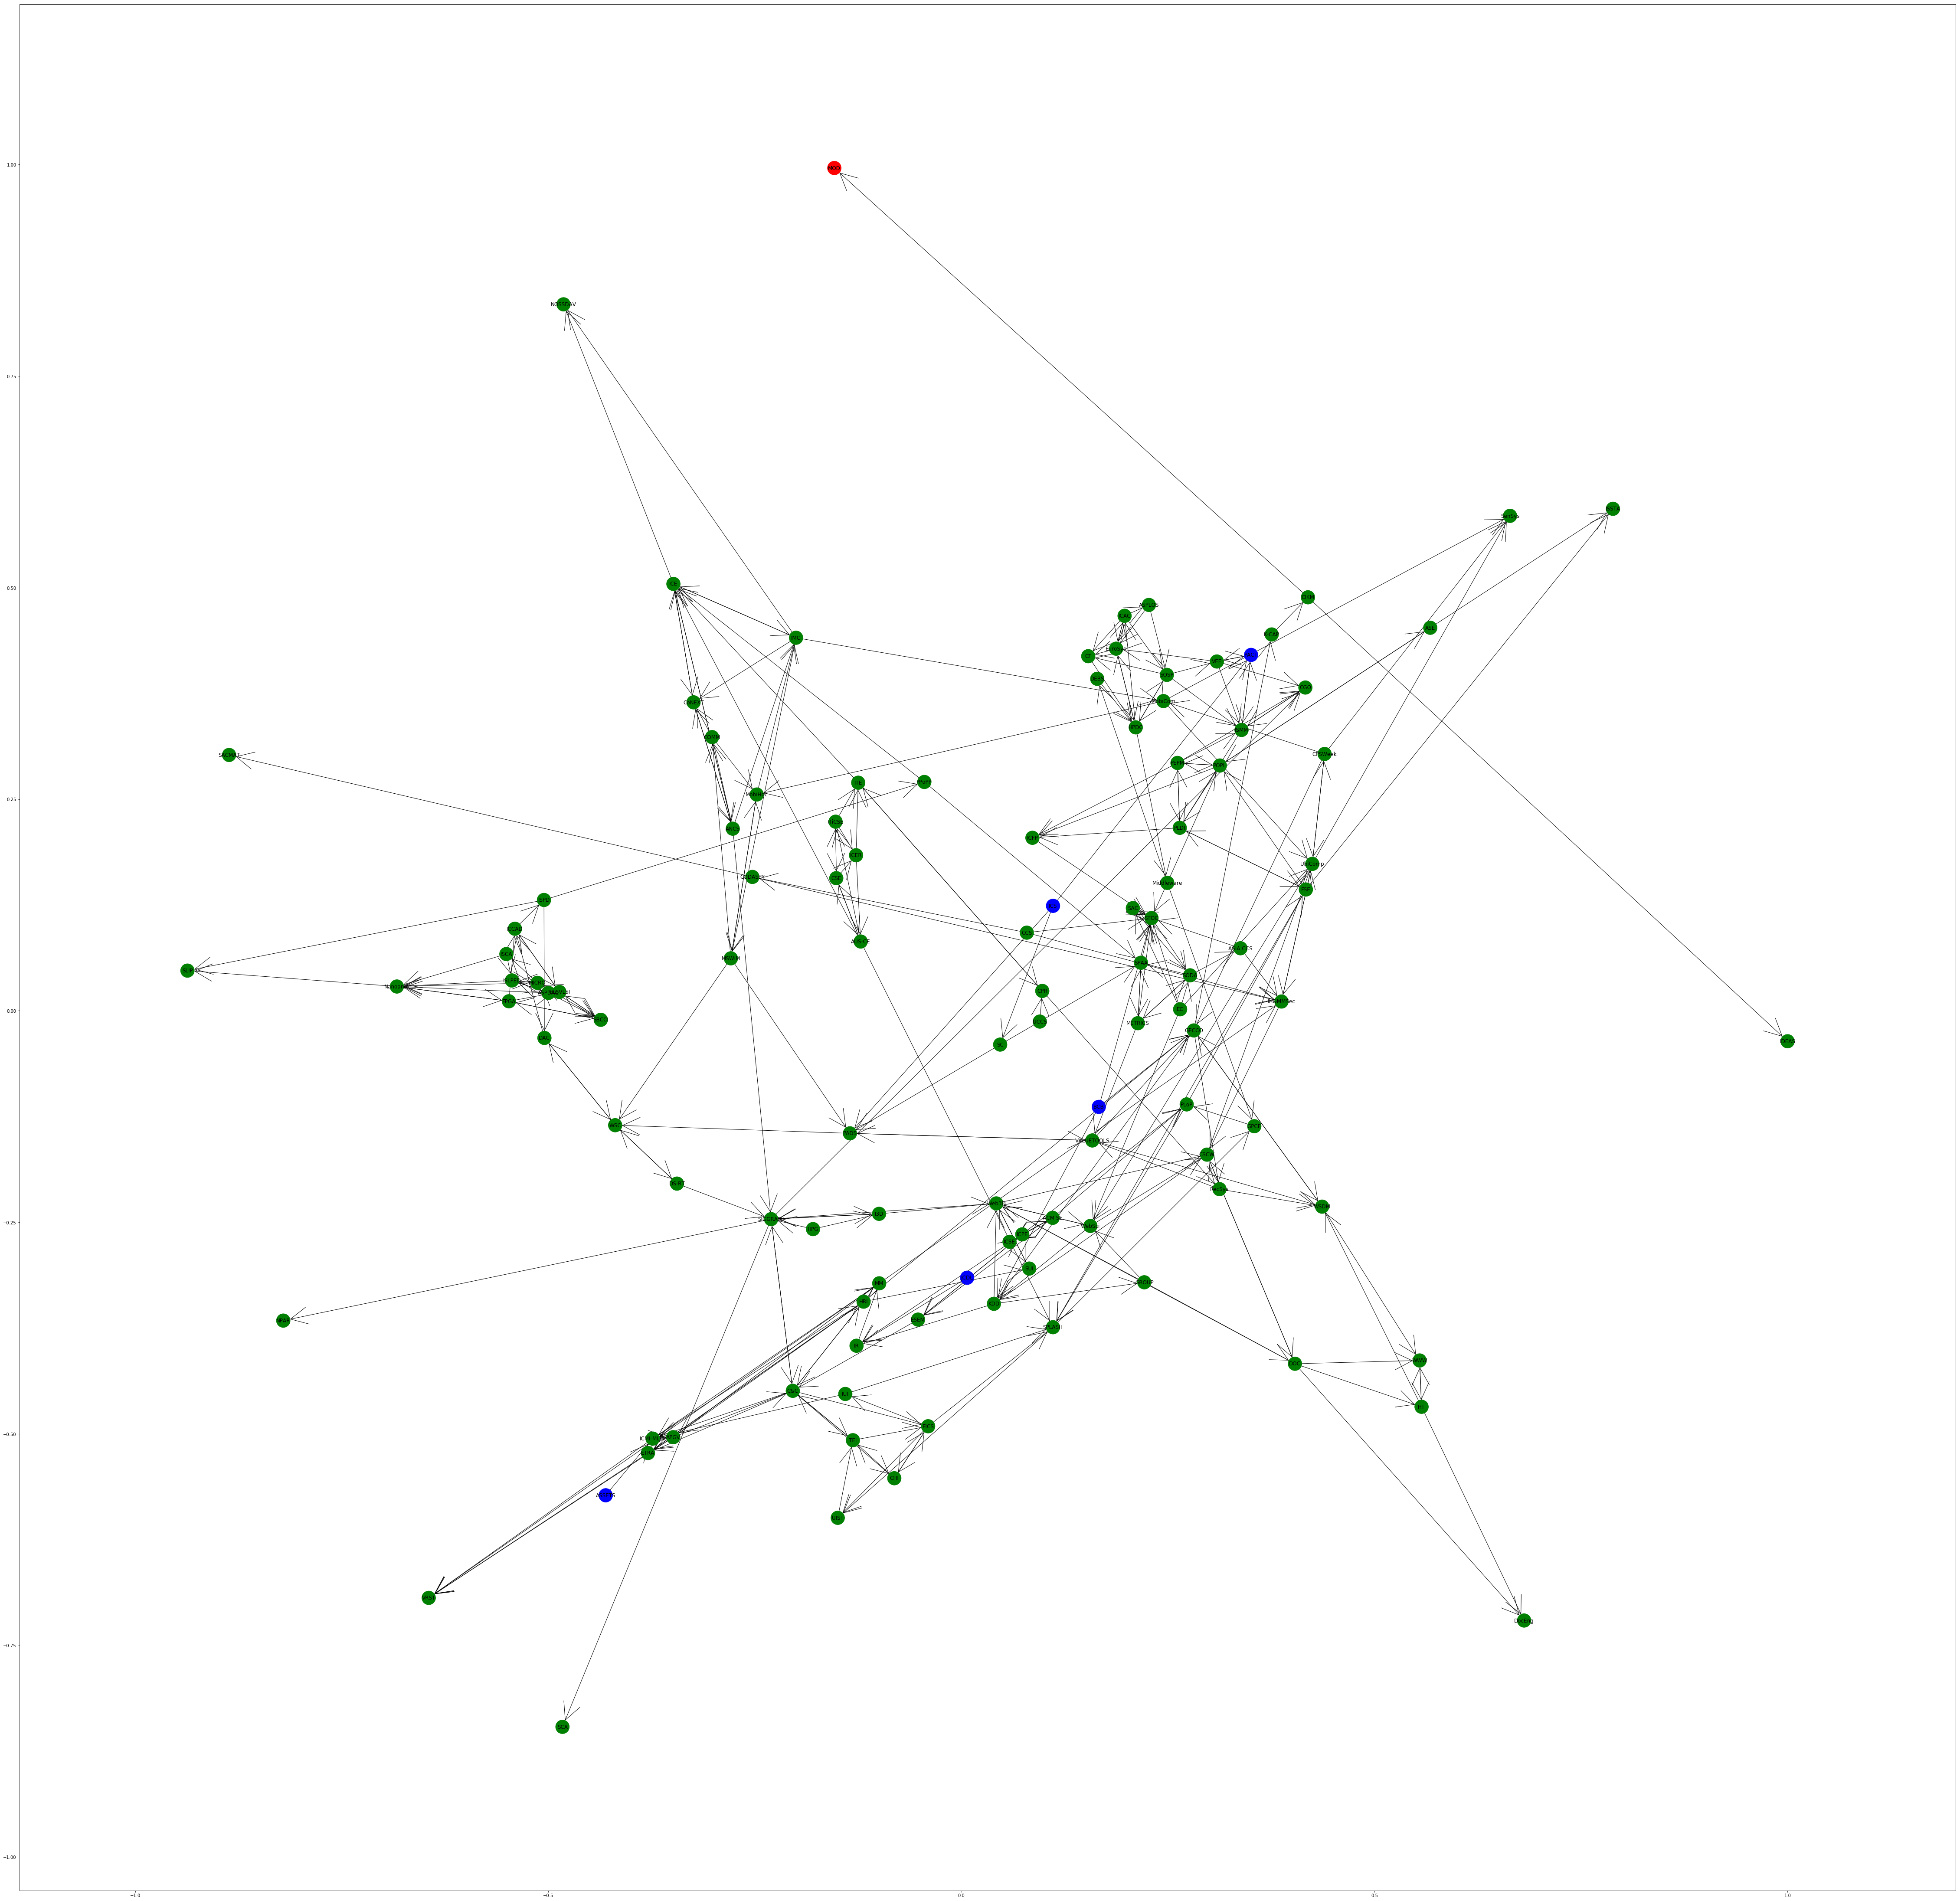

In [34]:

for t in range(time_period):
    if death_of_dease(g, nodes, t) == False:
        break
colors_new = []
for elem in nodes['state']:
    if elem == 0:
        colors_new.append('blue')
    elif elem == 1:
        colors_new.append('red')
    else:
        colors_new.append('green')
fig = plt.figure(figsize=(80, 80))
ax = fig.add_subplot(1, 1, 1)
nx.draw_networkx(g, ax=ax, arrowsize=100, arrowstyle='->', pos=pos, node_color=colors_new, node_size=1000, with_labels=True)
plt.savefig("to_second.png")
print('Number of nodes which were deseased in this period time = 8: {} from {}'.format(int(nodes['state'].where(nodes['state'] == 2).sum() / 2), len(nodes['id'])))
res1 = int(nodes['state'].where(nodes['state'] == 2).sum() / 2) / len(nodes['id'])
cost1 = int((nodes['state'].where(nodes['state'] == 2).sum() / 2)) * 120 - 120 * quant_vaccine + 500 * quant_vaccine
print('deseased / all:', res1)
print('cost: {}$'.format(int(cost1)))
while True:
    if death_of_dease(g, nodes, t) == False:
        break
    t += 1

# Second strategy.2

In [35]:
def edge_between_components(comp1, comp2, nodes, g, count):
    for node1 in comp1:
        for node2 in comp2:
            if g.has_edge(node1, node2) and (nodes['state'].iloc[nodes['id'][nodes['id'] == node1].index[0]] == 1):
                count += 1
                return (node1, node2)
            elif g.has_edge(node2, node1) and (nodes['state'].iloc[nodes['id'][nodes['id'] == node2].index[0]] == 1):
                count += 1
                return (node2, node1)
    return ()
            

In [36]:
nodes = nodes_new.copy()

quant_i = nodes['state'].where(nodes['state'] == 1).sum()
quant_s = 0
for elem in nodes['state'].where(nodes['state'] == 0):
    if elem == 0:
        quant_s += 1
print("Number of nodes type S:", quant_s)
quant_vaccine = int(quant_s * 0.1)
print('Number of Infectious nodes which can be vaccinated:', quant_vaccine)

count = 0

for elem in nx.strongly_connected_components(g):
    components.append((elem, len(elem)))
components = sorted(components, key=lambda x: -x[1])

comp = []
for i in range(quant_vaccine):
    for j in range(i + 1, quant_vaccine):
        edge = edge_between_components(components[i][0], components[j][0], nodes, g, count)

        if edge != ():
            comp.append(edge)


Number of nodes type S: 48
Number of Infectious nodes which can be vaccinated: 4


In [37]:
while count < quant_vaccine:
    tmp = random.randint(0, len(nodes['id']) - 1)
    while nodes['state'].iloc[tmp] != 0:
        tmp = random.randint(0, len(nodes['id']) - 1)
    nodes['state'].iloc[tmp] = 2
    count += 1

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Number of nodes which were deseased in this period time = 8: 108 from 113
deseased / all: 0.9557522123893806
cost: 14480$
Time of desease`s death 8


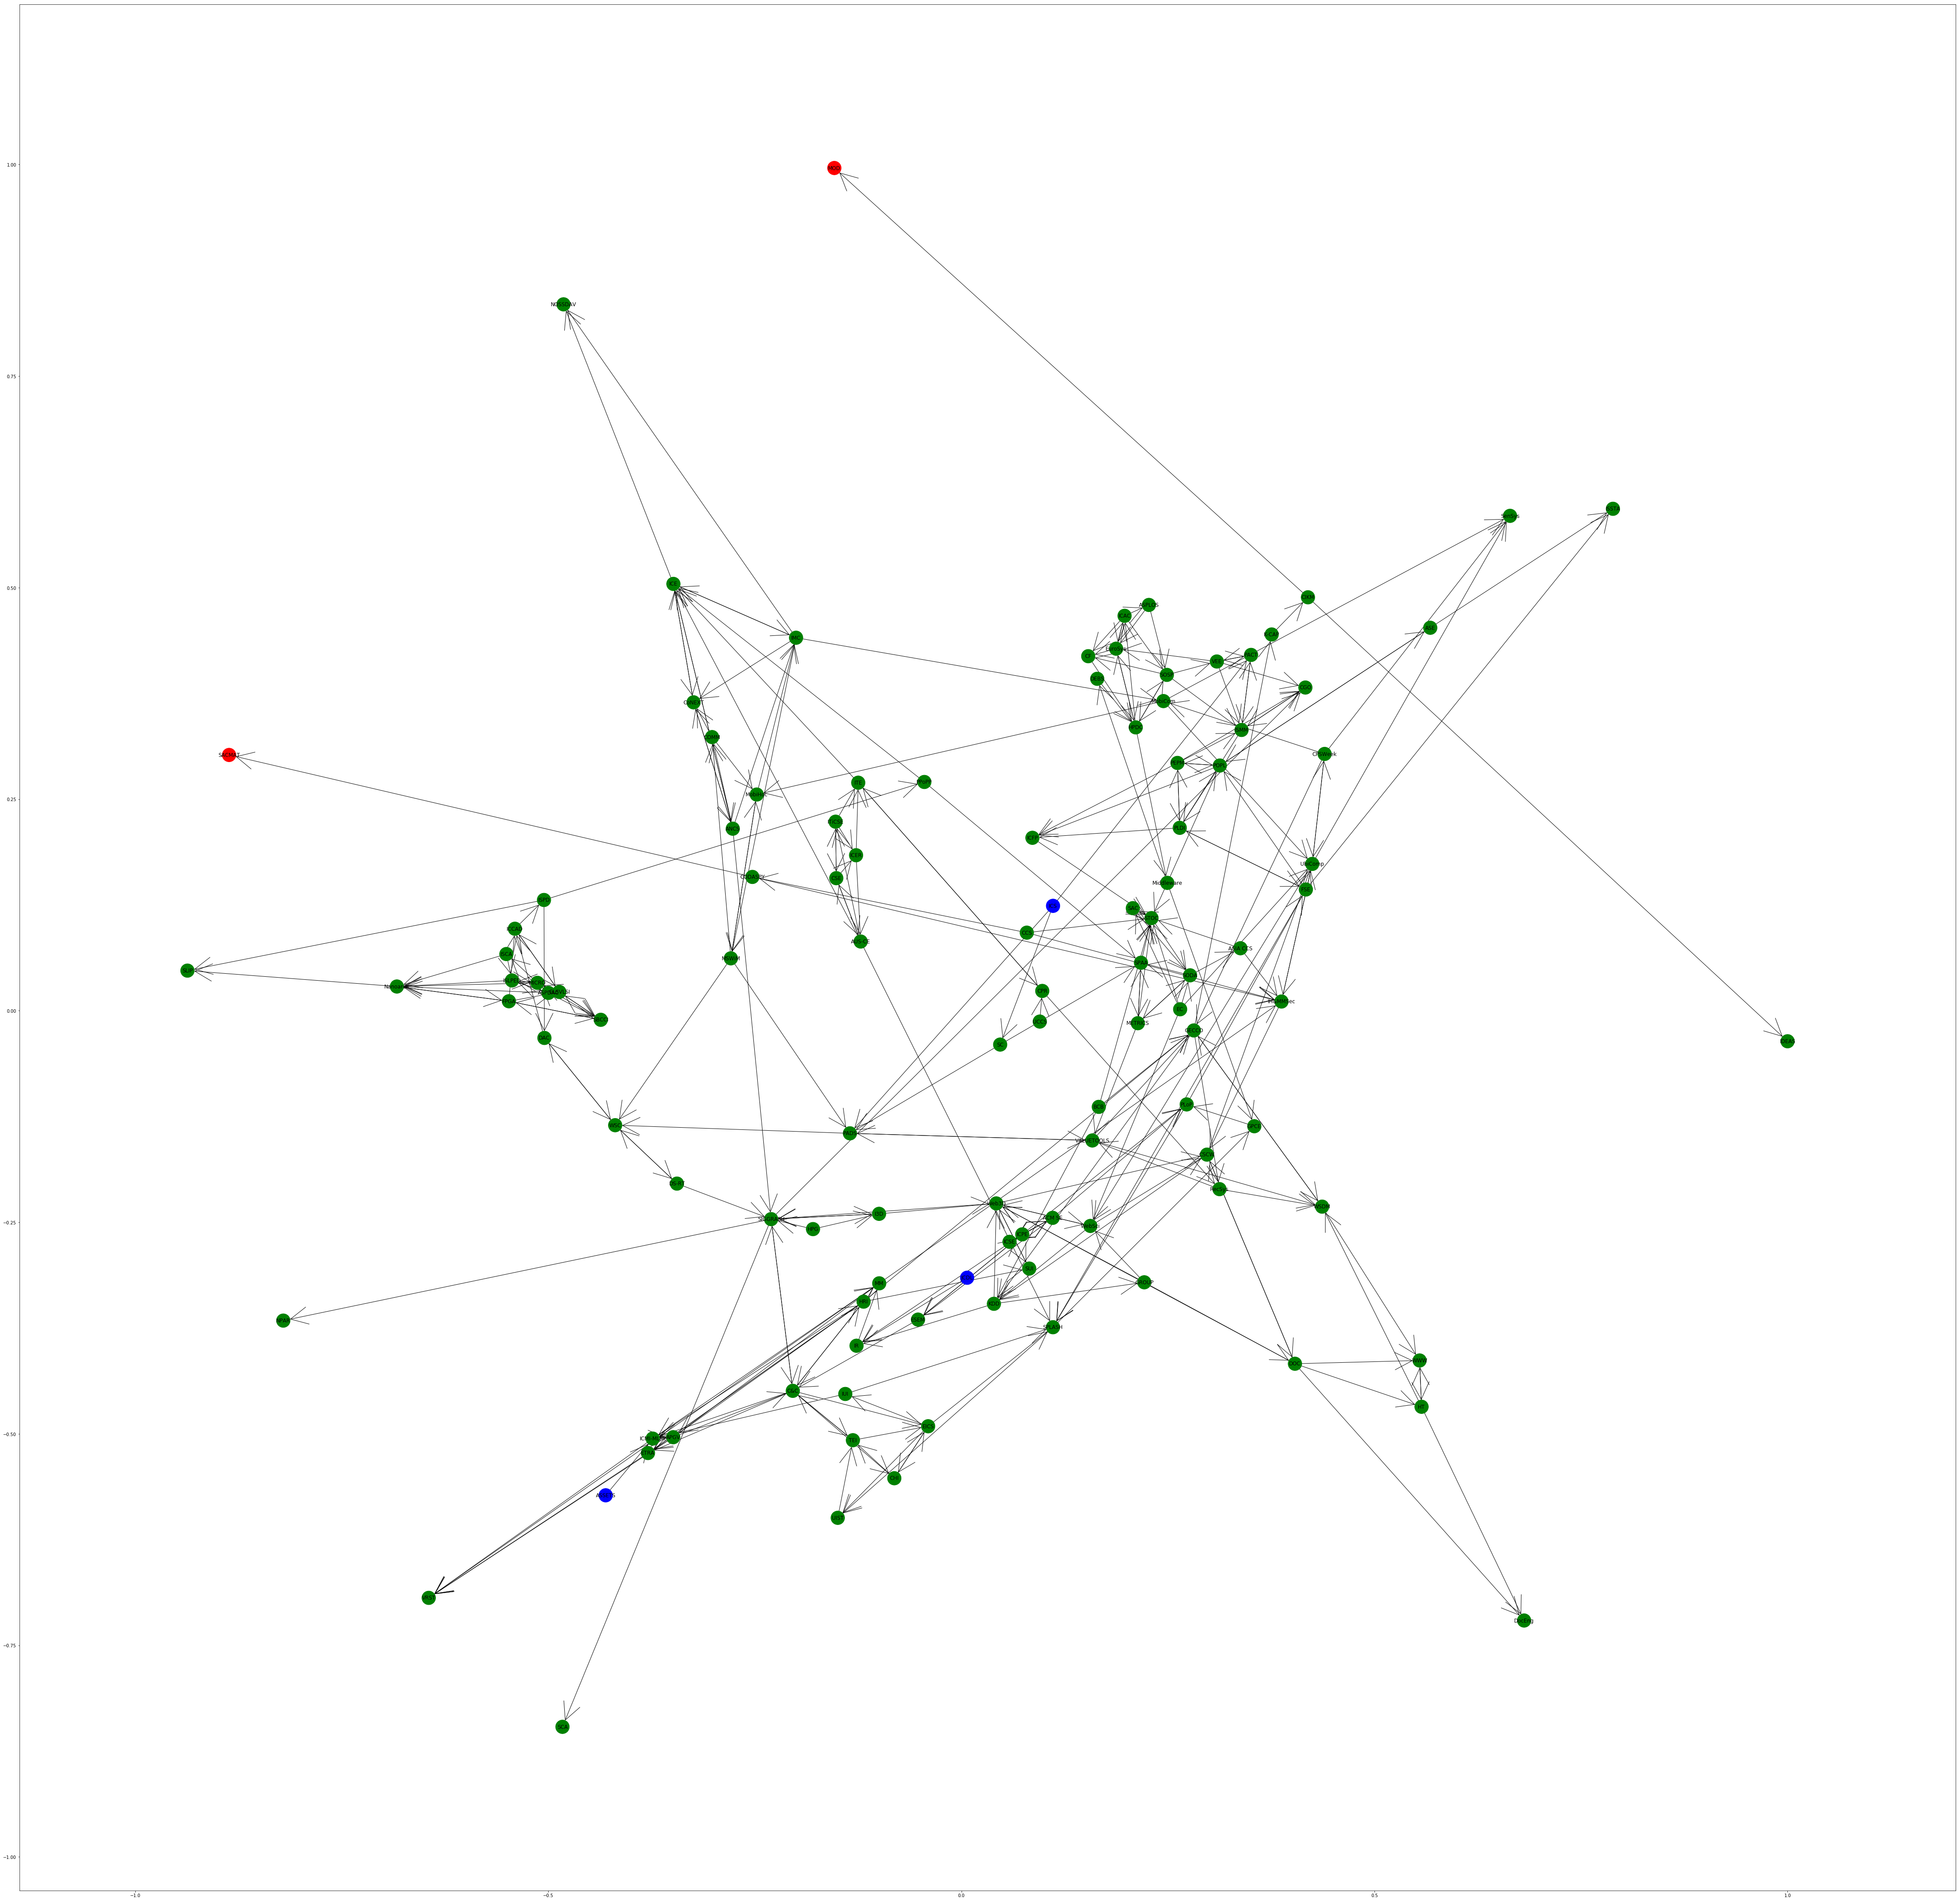

In [38]:
for t in range(time_period):
    if death_of_dease(g, nodes, t) == False:
        break
colors_new = []
for elem in nodes['state']:
    if elem == 0:
        colors_new.append('blue')
    elif elem == 1:
        colors_new.append('red')
    else:
        colors_new.append('green')
fig = plt.figure(figsize=(80, 80))
ax = fig.add_subplot(1, 1, 1)
nx.draw_networkx(g, ax=ax, arrowsize=100, arrowstyle='->', pos=pos, node_color=colors_new, node_size=1000, with_labels=True)
plt.savefig("to_second.png")
print('Number of nodes which were deseased in this period time = 8: {} from {}'.format(int(nodes['state'].where(nodes['state'] == 2).sum() / 2), len(nodes['id'])))
res1 = int(nodes['state'].where(nodes['state'] == 2).sum() / 2) / len(nodes['id'])
cost1 = int((nodes['state'].where(nodes['state'] == 2).sum() / 2)) * 120 - 120 * quant_vaccine + 500 * quant_vaccine
print('deseased / all:', res1)
print('cost: {}$'.format(int(cost1)))
while True:
    if death_of_dease(g, nodes, t) == False:
        break
    t += 1

# Conclusion

We received results for 3 strategy and compare it with 'without strategy'.

***Without strategy(without vaccination for comparison)***
* 107 people were infected
* 12840$ were spent
* Desease`s life was 9

***Strategy 1***

* 101 people were nfected
* 14120$ were spent
* Desease`s life was 9

***Strategy 2***(modified first strategy)

* 103 people were infected
* 14360$ were spent
* Desease`s life was 9

***Strategy 2.2***

* 104 people were infected
* 14480$ were spent
* Desease`s life was 8

I think the first strategy was the best because the quantity of infected people and spent money was least.